In [1]:
## importing libraries
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import simplejson as json
import datetime
import time
plt.style.use('dark_background')

## Easing the limits on the number of output columns and rows shown because the dataset is massive 
## and we will sometimes need to take a closer look at the data structure.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)


In [2]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import validation_curve
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from scipy.spatial.distance import cdist
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA

In [3]:
## defining the functions that will extract the values out of json-like columns

def todict(dic, key, value):
    if key in dic:
        dic[key].append(value)
    else:
        dic[key] = [value]
    return dic

def resolve_json(hitsdic, hits_json, key='NoneName'):
    if type(hits_json) == list:
        if len(hits_json) == 0:
            pass
        else:
            for subjson in hits_json:
                hitsdic = resolve_json(hitsdic, subjson)
    elif type(hits_json) == dict:
        for i in hits_json.keys():
            hitsdic = resolve_json(hitsdic, hits_json[i],i)
    else:
        hitsdic = todict(hitsdic, key, hits_json)
    return hitsdic

def complex_replace(x):
    dic = {}
    return resolve_json(dic, json.loads(x.replace('\'','\"'). \
                                        replace('TRUE','true'). \
                                        replace('True','true'). \
                                        replace('FALSE','false'). \
                                        replace('False','false'). \
                                        replace(', \"',', !&~'). \
                                        replace('\", ','!&~, '). \
                                        replace('\": ','!&~: '). \
                                        replace(': \"',': !&~'). \
                                        replace(' {\"',' {!&~'). \
                                        replace('\"}, ','!&~}, '). \
                                        replace('[{\"','[{!&~'). \
                                        replace('\"}]','!&~}]'). \
                                        replace('\"','_'). \
                                        replace('!&~','\"'). \
                                        encode('gbk','ignore'). \
                                        decode('utf-8','ignore'). \
                                        replace('\\','')))


def replace(x):
    return  json.loads(x.replace('\'','\"').replace('False', 'false').replace('True','true'))


In [4]:
## Read data
data = pd.read_csv('data.csv',dtype={'fullVisitorId': 'str'})
# no longer need this
#df = pd.concat([df1,pd.io.json.json_normalize(df1['geoNetwork'].apply(eval)),
#                pd.io.json.json_normalize(df1['device'].apply(eval)),pd.io.json.json_normalize(df1['trafficSource'].apply(eval))])


In [5]:
data.shape

(20000, 22)

# Data Flattening

In [6]:
## extracting the columns out of json and dict like columns
traf_cols = pd.DataFrame(json_normalize(data['trafficSource'].apply(eval))[["medium","source"]])
geo_cols = pd.DataFrame(pd.io.json.json_normalize(data["geoNetwork"].apply(eval))[["country","continent"]])
dev_cols = pd.DataFrame(pd.io.json.json_normalize(data["device"].apply(eval))[["browser","deviceCategory","operatingSystem"]])
#custdims_cols = json_normalize(data['customDimensions'].apply(complex_replace)) #dont need this, nothing useful in there
# hit_cols = pd.DataFrame(json_normalize(data['hits'].apply(complex_replace))) #leaving this because it still has lists

In [7]:
## Combining all the columns extracted in the previous step and removing the complex column types
df = pd.DataFrame(pd.concat([data.drop(["trafficSource","geoNetwork","device","hits","customDimensions"],axis=1),dev_cols,traf_cols,geo_cols],axis=1,sort=False))

In [8]:
## this suggests that the data concatenation worked fine
df.shape

(20000, 24)

# Descriptives

#### I will start with exploring the dataset in general and then dive deeper into specific variables that make most logical sense

###### Lets check which variables we have in the flattened dataset and what kind of values can we expect

In [9]:
df.head(2)

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,browser,deviceCategory,operatingSystem,medium,source,country,continent
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,1.000,1,1.000,1.000,1.000,nan,nan,nan,nan,1,Firefox,desktop,Windows,organic,google,Germany,Europe
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,nan,2,nan,2.000,2.000,28.000,nan,nan,nan,1,Chrome,desktop,Chrome OS,referral,sites.google.com,United States,Americas


In [10]:
df.dtypes

channelGrouping                    object
date                                int64
fullVisitorId                      object
socialEngagementType               object
visitId                             int64
visitNumber                         int64
visitStartTime                      int64
totals_bounces                    float64
totals_hits                         int64
totals_newVisits                  float64
totals_pageviews                  float64
totals_sessionQualityDim          float64
totals_timeOnSite                 float64
totals_totalTransactionRevenue    float64
totals_transactionRevenue         float64
totals_transactions               float64
totals_visits                       int64
browser                            object
deviceCategory                     object
operatingSystem                    object
medium                             object
source                             object
country                            object
continent                         

###### we can see that some of the variables need correction. eg date is coded as a numeric variable. Similarly time is also coded as an integer. We can change it to POSIX object to perhaps see any time relation within the dataset. We can also remove socialEngagementType as the entire column is the same value. visitId needs to be a string variable, that can be changed in the original data import perhaps, but since reflattening the data will take a bit of time, i'll just change it here. The variable of interest is totals_transactionRevenue so we need to change the NaNs to 0. The totals_transactions also needs the same treatment. 

In [11]:
df.describe(include = 'all')

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,browser,deviceCategory,operatingSystem,medium,source,country,continent
count,20000,20000.000,20000,20000,20000.000,20000.000,20000.000,9873.000,20000.000,15088.000,19999.000,9120.000,10101.000,193.000,193.000,196.000,20000.000,20000,20000,20000,20000,20000,20000,20000
unique,7,nan,18384,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,25,3,16,6,78,155,6
top,Organic Search,nan,9127817804140120297,Not Socially Engaged,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Chrome,desktop,Windows,(none),(direct),United States,Americas
freq,9535,nan,8,20000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,13978,13988,7651,8198,8198,8663,10521
mean,NaN,20170407.650,NaN,NaN,1498277361.058,2.264,1498277361.897,1.000,4.794,1.000,3.972,4.456,264.245,127819170.984,108763626.943,1.041,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,4737.638,NaN,NaN,15657973.827,7.877,15657973.500,0.000,9.080,0.000,6.499,12.594,459.176,243226248.254,171192435.947,0.223,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,20160902.000,NaN,NaN,1472799309.000,1.000,1472799601.000,1.000,1.000,1.000,1.000,1.000,1.000,4990000.000,1990000.000,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,20170203.000,NaN,NaN,1486118285.750,1.000,1486118285.750,1.000,1.000,1.000,1.000,1.000,35.000,27990000.000,21020000.000,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,20170623.000,NaN,NaN,1498247103.500,1.000,1498247103.500,1.000,2.000,1.000,2.000,1.000,94.000,51710000.000,44580000.000,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,20171130.000,NaN,NaN,1512037938.000,1.000,1512037938.000,1.000,5.000,1.000,4.000,1.000,270.000,114160000.000,108720000.000,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### data cleaning as suggested in the second last cell

In [12]:
## cleaning the date first. Time is in timestamp format so we dont need to clean that up.
df['date2'] = df['date'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))

In [13]:
## converting the visit ID to string
## actually, not the best idea. visit id is more like the "nth number of visit by the visitor"
## df['visitId'] = str(df['visitId'])

In [14]:
## removing social engagement
df = df.drop(["socialEngagementType","totals_totalTransactionRevenue"], axis = 1)

In [15]:
type(df['totals_transactionRevenue'].head()[1])

numpy.float64

In [16]:
## replacing NaNs from target variable to 0
df['totals_transactionRevenue'].fillna(0,inplace=True)
df['totals_transactions'].fillna(0,inplace=True)
## replacing some of the metrics with nan values to 0. This is because usually when Google Analytics has these numbers missing, they are actually 0 or very close to zero.
## so it is reasonable to fill them in with zeros
df['totals_bounces'].fillna(0,inplace=True)
df['totals_newVisits'].fillna(0,inplace=True)
df['totals_timeOnSite'].fillna(0,inplace=True)
df['totals_pageviews'].fillna(0,inplace=True)

In [17]:
df.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,totals_visits,browser,deviceCategory,operatingSystem,medium,source,country,continent,date2
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,1.000,1,1.000,1.000,1.000,0.000,0.000,0.000,1,Firefox,desktop,Windows,organic,google,Germany,Europe,2017-10-16
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,0.000,2,0.000,2.000,2.000,28.000,0.000,0.000,1,Chrome,desktop,Chrome OS,referral,sites.google.com,United States,Americas,2017-10-16
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,0.000,2,1.000,2.000,1.000,38.000,0.000,0.000,1,Chrome,mobile,Android,(none),(direct),United States,Americas,2017-10-16
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,0.000,2,1.000,2.000,1.000,1.000,0.000,0.000,1,Chrome,desktop,Windows,organic,google,Turkey,Asia,2017-10-16
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,0.000,2,1.000,2.000,1.000,52.000,0.000,0.000,1,Chrome,desktop,Windows,organic,google,Mexico,Americas,2017-10-16


# Data Visualization

#### In this section, I will try to visually see which variables could be important in predicting the dependent variable. I will be using the average revenue per transaction for each group I make

###### starting with a histogram of the dependent variable to see what the variable actually looks like. We see a few problems right off the bat.. The first is that the units of our dependent variable are extremely high. The second is that most of the data is zero. To fix the first problem, natral log of the variable could be taken.

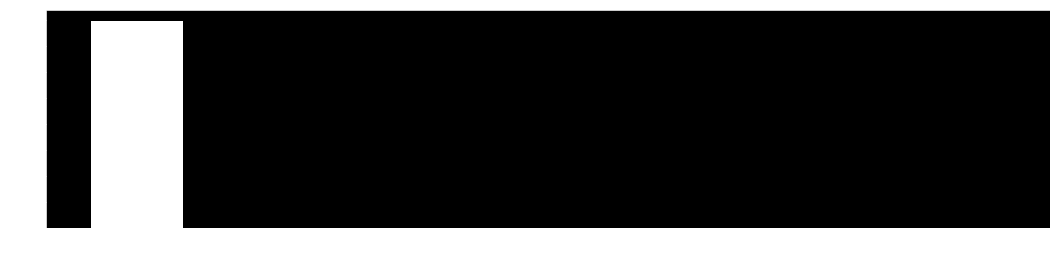

In [18]:
plt.figure(figsize=(18,4))
plt.hist(df['totals_transactionRevenue'], color="white")
plt.show()

In [19]:
df["totals_transactionRevenue2"] = np.log1p(df["totals_transactionRevenue"])
df["totals_transactionRevenue_zero"] = df['totals_transactionRevenue'].apply(lambda x: "no" if x>0 else "yes")

###### we can see that there is only 193 values with a non zero revenue. this will cause problems in the regression used later on as all models will try to predict 0 very heavily

In [20]:
t1 = df[["totals_transactionRevenue_zero","totals_transactionRevenue","totals_transactionRevenue2"]].groupby("totals_transactionRevenue_zero", as_index=False).agg({'totals_transactionRevenue':["mean","count"],"totals_transactionRevenue2":["mean","count"]})
t1

totals_transactionRevenue_zero totals_transactionRevenue         \
                                                      mean  count   
0                             no             108763626.943    193   
1                            yes                     0.000  19807   

  totals_transactionRevenue2         
                        mean  count  
0                     17.735    193  
1                      0.000  19807

###### From the scatter plot below, we can see the dearth of non-zero revenues. Less than 1 percent of the sessions brought any revenue at all

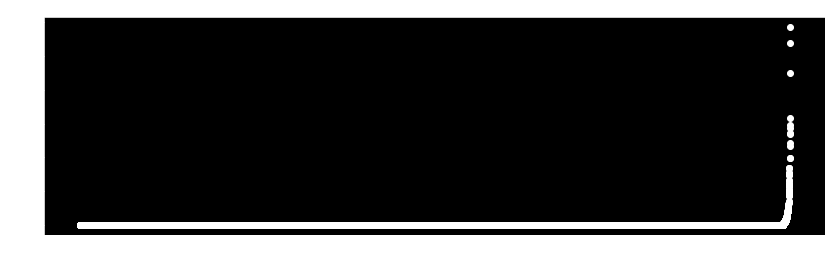

In [21]:
t2 = df["totals_transactionRevenue"].reset_index()

plt.figure(figsize=(14,4))
plt.scatter(range(t2.shape[0]), np.sort(t2["totals_transactionRevenue"].values), c= "white")
plt.xlabel('index', fontsize=10)
plt.ylabel('Revenue', fontsize=10)
plt.show()

###### The following chart shows a clearer picture

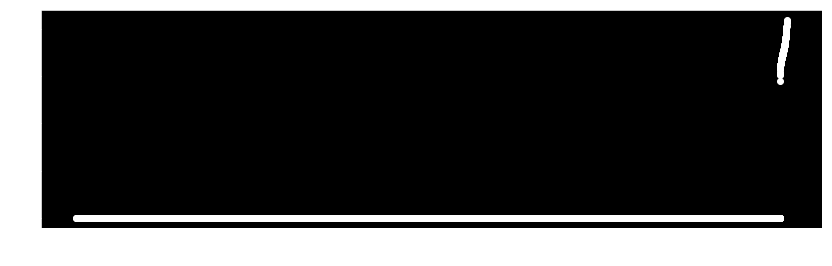

In [22]:
t2 = df["totals_transactionRevenue2"].reset_index()

plt.figure(figsize=(14,4))
plt.scatter(range(t2.shape[0]), np.sort(t2["totals_transactionRevenue2"].values), c= "white")
plt.xlabel('index', fontsize=10)
plt.ylabel('log of Revenue', fontsize=10)
plt.show()

###### Lets break it down by the channel grouping which is an important variable for ecommerce. We can see that referral links have the highest average revenue per transaction

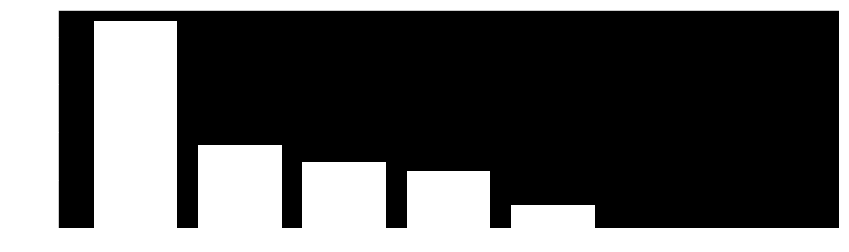

In [23]:
t3 = df[["channelGrouping","totals_transactionRevenue"]].groupby("channelGrouping",  as_index=False).mean().sort_values(by = "totals_transactionRevenue" ,ascending=False)
plt.figure(figsize=(14,4))
plt.bar(t3['channelGrouping'],t3["totals_transactionRevenue"], color = "white")
plt.show()

###### We also have  few other categorical variables that could be interesting to look at namely: browser, deviceCategory, operatingSystem, medium, source, country, continent. I'll look at the device category to see if mobile users pay more, and also the country to see if people in a certain country are bigger fans of Google merch. We see that desktop users pay more, this is because as great our phones have become, people still prefer using desktops where adding payment information is easier.

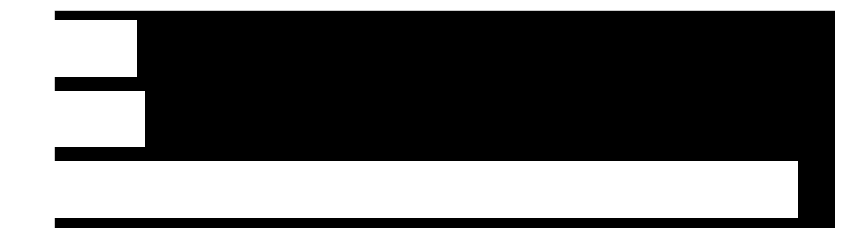

In [24]:
t4 = df[["deviceCategory","totals_transactionRevenue"]].groupby("deviceCategory",  as_index=False).mean().sort_values(by = "totals_transactionRevenue" ,ascending=False)
plt.figure(figsize=(14,4))
plt.barh(t4['deviceCategory'],t4["totals_transactionRevenue"], color = "white")
plt.show()

###### Columbia is really high in terms of average revenue per session. This might be because of very few transactions woth high revenue numbers

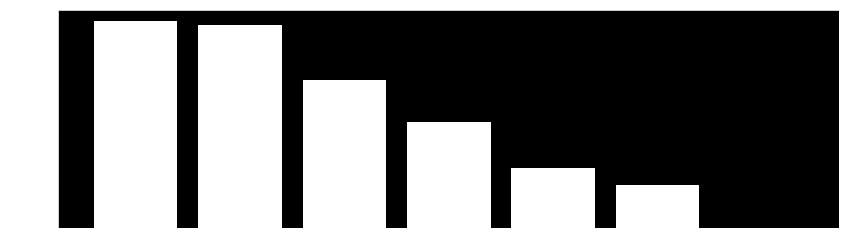

In [25]:
t5 = df[["country","totals_transactionRevenue"]].groupby("country",  as_index=False).mean().sort_values(by = "totals_transactionRevenue" ,ascending=False).head(7)
plt.figure(figsize=(14,4))
plt.bar(t5['country'],t5["totals_transactionRevenue"], color = "white")
plt.show()

###### Dividing into train and test sets, but first lets limit our data to actual independent and dependent variables. I will remove the ID variables first so that getting dummy variables is easier.

In [26]:
df2 = df.drop(["date","fullVisitorId","visitId","visitStartTime","date2","totals_transactionRevenue2", "totals_transactions","totals_transactionRevenue_zero","totals_sessionQualityDim"],axis=1)

# Dummy coding
##### To change catogorical variables into a set of binary variables

In [27]:
## converting all object variables to categorical for faster processing and then creating dummies
obj_cols = df2.select_dtypes(include=['object'])
for col in obj_cols:
    df2[col] = df2[col].astype('category')
df3 = pd.get_dummies(df2,drop_first = True)

In [28]:
X = df3.drop(["totals_transactionRevenue"], axis=1)
y = df3["totals_transactionRevenue"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

# Data Scaling
##### I am inclined towards using standardization for feature scaling because it turns the data into standard deviation and is easy to interpret. It is also very widely used in machine learning algorithms. Is also useful in comparing variables with different units. Also the scaler will be trained on the train set and will be used to transform both the train and test set so that information about the mean and standard deviation does not leak about the test set.

In [29]:
num_cols = ['visitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_timeOnSite','totals_visits']
scaler = preprocessing.StandardScaler().fit(Xtrain[num_cols])
Xtrain[num_cols] = scaler.transform(Xtrain[num_cols])
Xtest[num_cols] = scaler.transform(Xtest[num_cols])

D:\Downloads\software\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Downloads\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Downloads\software\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: S

# Evaluation Criteria
##### I will be using RMSE to evaluate the criteria because it is interpretable in the units of the dependent variable. Lowest RMSE on validation set would be the chosen model. Defining the rmse function here to use in the make_scorer function as sklearn does not have rmse as one of the built in scorers

In [30]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))

# Modelling

### Supervised Learning 1: Ridge Regression
##### Starting with the ridge regression. I have previously never worked with ridge/lasso so I want to use this project to explore at least one of these techniques

In [31]:
alphas = np.array([2,1,0.1,0.01,0.001,0.0001]) # alpha parameters to test in grid search
# Grid Search for Algorithm Tuning
grid_ridge = GridSearchCV(cv = 5, estimator = Ridge(), scoring = make_scorer(rmse, greater_is_better = False), param_grid = dict(alpha = alphas)).fit(Xtrain, ytrain)
print("training RMSE: ", rmse(ytrain, grid_ridge.predict(Xtrain)))
print("testing RMSE:  ", rmse(ytest, grid_ridge.predict(Xtest)))
print("Best alpha parameter: ", grid_ridge.best_estimator_.alpha)

training RMSE:  19461078.47484234
testing RMSE:   17506169.064763565
Best alpha parameter:  2.0


##### We can see from the chart below that increasing alpha keeps decreasing our model error. This may mean that our model has very high variance and bias and that it is not a good model to work with. The validation curve later also shows that the high bias and variance and that the alpha factor has very little impact on the model performance

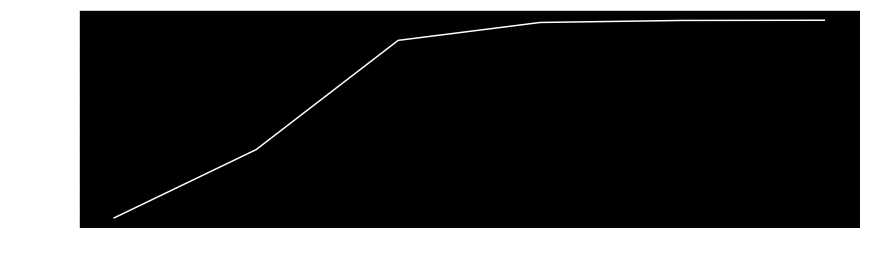

In [32]:
fig, ax = plt.subplots(1,1,figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
alphas2 = list(map(str,alphas))
ax.plot(alphas2,grid_ridge.cv_results_['mean_test_score']*-1, color = "white")
plt.xlabel('alpha param')
plt.ylabel('score');

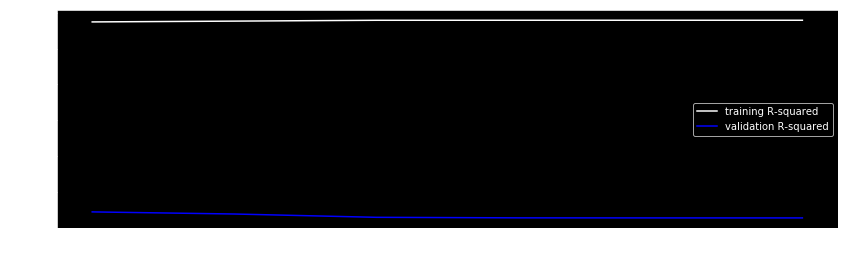

In [33]:
train_score, val_score = validation_curve(Ridge(), Xtrain, ytrain,'alpha', alphas, cv=5, scoring = "r2")
plt.subplots(1,1, figsize =(14,4))
plt.plot(alphas2, np.mean(train_score, 1), color='white', label='training R-squared')
plt.plot(alphas2, np.mean(val_score, 1), color='blue', label='validation R-squared')
plt.legend(loc='best')
plt.xlabel('alpha param')
plt.ylabel('R squared');

### Supervised Learning 2: Regression Tree
##### I will train a regression tree as the second model 

In [34]:
depths = np.array([1,2,5,10,20,30,40,296]) # prepare a range of depth values to test
# create and fit a ridge regression model, testing each alpha
grid_regtree = GridSearchCV(cv = 5, estimator = DecisionTreeRegressor(), scoring = make_scorer(rmse, greater_is_better = False), param_grid = dict(max_depth = depths)).fit(Xtrain,ytrain)
# summarize the results of the grid search
print("training RMSE: ", rmse(ytrain, grid_regtree.predict(Xtrain)))
print("testing RMSE:  ", rmse(ytest,  grid_regtree.predict(Xtest )))
print("max depth of best tree: " ,grid_regtree.best_estimator_.max_depth)

training RMSE:  19548934.700272918
testing RMSE:   18219318.983098
max depth of best tree:  1


##### We can see that adding features is actually decreasing model performance, which is also an indication of high variance. It may also imply that a null model is actually better than any actual ML models because of so many zeros in our data.

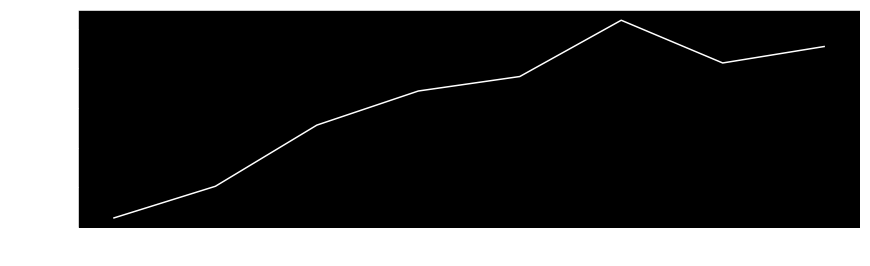

In [35]:
fig, ax = plt.subplots(1,1,figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
depths2 = list(map(str,depths))
ax.plot(depths2,grid_regtree.cv_results_['mean_test_score']*-1, color = "white")
plt.xlabel('Tree depth')
plt.ylabel('validation set RMSE');

##### The validation curve for R squared makes the high bias and variance even more obvious to see. Deeper trees have R squared values below zero! A 1 level deep model has the highest r2 on the testing set.

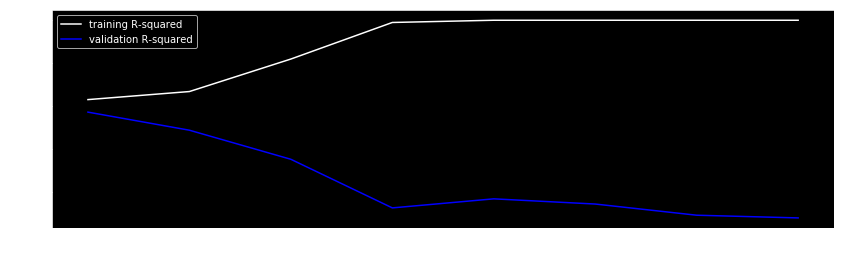

In [36]:
train_score, val_score = validation_curve(DecisionTreeRegressor(), Xtrain, ytrain,'max_depth', depths, cv=5, scoring = "r2")
plt.subplots(1,1, figsize =(14,4))
plt.plot(depths2, np.mean(train_score, 1), color='white', label='training R-squared')
plt.plot(depths2, np.mean(val_score, 1), color='blue', label='validation R-squared')
plt.legend(loc='best')
plt.xlabel('tree depth')
plt.ylabel('R squared');

##### I tried randomized search also just in the case that none of the depth values I added in the grid were optimal. 

In [37]:
# prepare a uniform distribution to sample for the max depth parameter and then train the model
param_grid = {'max_depth': sp_randint(1,296)}
rsearch = RandomizedSearchCV(cv= 5,estimator = DecisionTreeRegressor(), scoring = make_scorer(rmse,greater_is_better=False), param_distributions=param_grid, n_iter=100).fit(Xtrain, ytrain)
print("best max depth: ", rsearch.best_estimator_.max_depth)

best max depth:  1


### Unsupervised Model Clustering 1: K means
##### starting with 2 clusters because I want to see if it can predict the zero revenue sessions vs positive revenue sessions

In [38]:
kmeans = KMeans(n_clusters=2).fit(Xtrain) 
t6 = pd.DataFrame(kmeans.predict(Xtest),ytest)
t6 = t6.sort_values(by="totals_transactionRevenue").reset_index()
t6 = t6.rename(index=int, columns={0: "cluster"})
t6['cluster'] = t6["cluster"].astype('category')
t6['color'] = t6['cluster'].apply(lambda x: "white" if x == 0 else "blue")


##### We can see that the clusters are pretty good in terms of figuring out which sessions had non zero revenue. one of the Clusters has almost no rows with non zero revenue, while the other has a mix of both

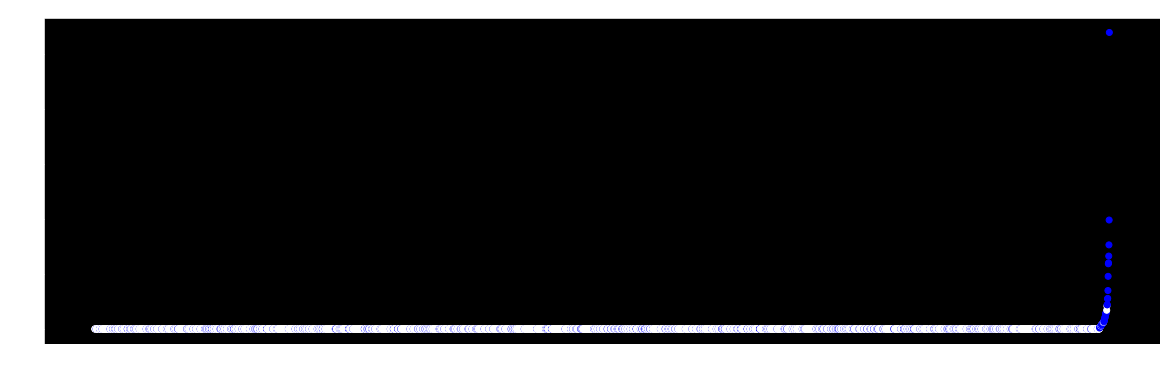

In [77]:
plt.figure(figsize=(20,6))
colors = {'0':'white', '1':'blue'}
plt.scatter(range(5000), np.sort(t6["totals_transactionRevenue"].values), c = t6["color"])
plt.xlabel('index', fontsize=10)
plt.ylabel('Revenue', fontsize=10)
plt.show()

##### Now ploting the WSS for k from 1 through 20 to see if we can apply the elbow test here. As is the case with complex datasets, there is no clear elbow and we see decreasing marginal improvement in wss as we increase K. The WSS plot does show a minor elbow at 4 clusters though, so lets check if k=4 is better in predicting non-revenue rows versus revenue rows

In [40]:
# credit to https://pythonprogramminglanguage.com/kmeans-elbow-method/ for the WSS calculation
wss = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Xtrain)
    wss.append(sum(np.min(cdist(Xtrain, kmeans.cluster_centers_, 'euclidean'), axis=1)) / Xtrain.shape[0])

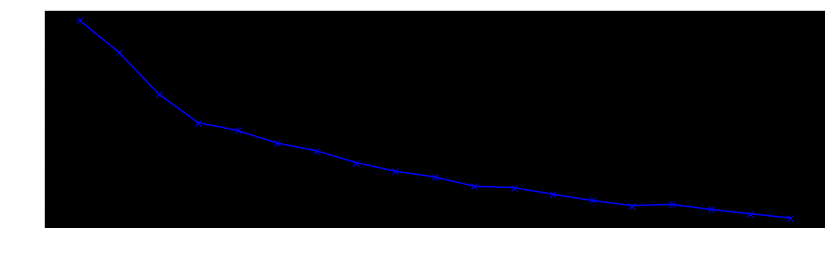

In [41]:
K = list(map(str,K))
plt.figure(figsize=(14,4))
plt.plot(K, wss, 'bx-')
plt.xlabel('k')
plt.ylabel('WSS')
plt.show()

In [89]:
kmeans = KMeans(n_clusters=4).fit(Xtrain) 
t7 = pd.DataFrame(kmeans.predict(Xtest),ytest)


In [90]:
colors = {'0':'white', '1':'blue','2':'red', '3':'yellow','4':'green', '5':'orange'}
t7 = t7.sort_values(by="totals_transactionRevenue").reset_index()
t7 = t7.rename(index=int, columns={0: "cluster"})
t7['cluster'] = t7["cluster"].astype('str')
t7['cluster'] = t7["cluster"].astype('category')
t7['color'] = t7['cluster'].apply(lambda x: colors[x])

##### Still looks like that all of the non-zero rows are in one of the clusters. The difference is that now, we have less of zero-revenue rows in the cluster so it is more "pure"

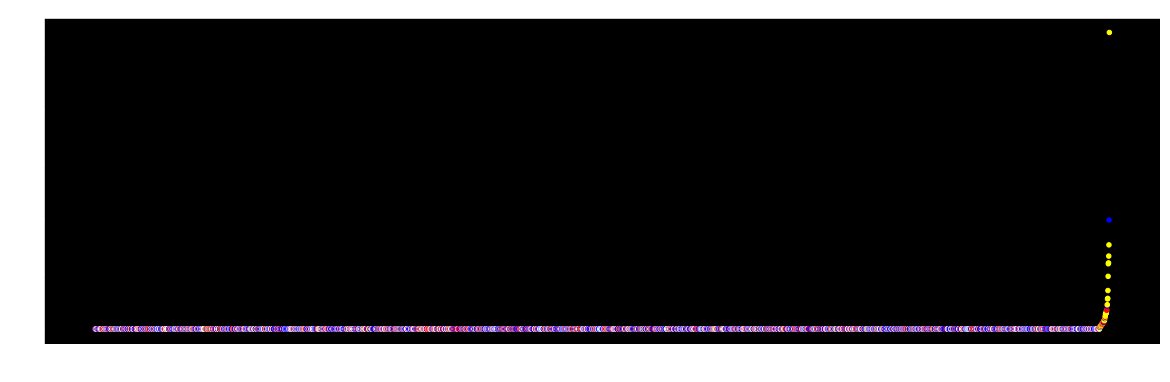

In [91]:
plt.figure(figsize=(20,6))
colors = {'0':'white', '1':'blue','2':'red', '3':'yellow','4':'green', '5':'orange'}
plt.scatter(range(t7.shape[0]), np.sort(t7["totals_transactionRevenue"].values), c = t7["color"], s= 20 )
plt.xlabel('index', fontsize=10)
plt.ylabel('Revenue', fontsize=10)
plt.show()

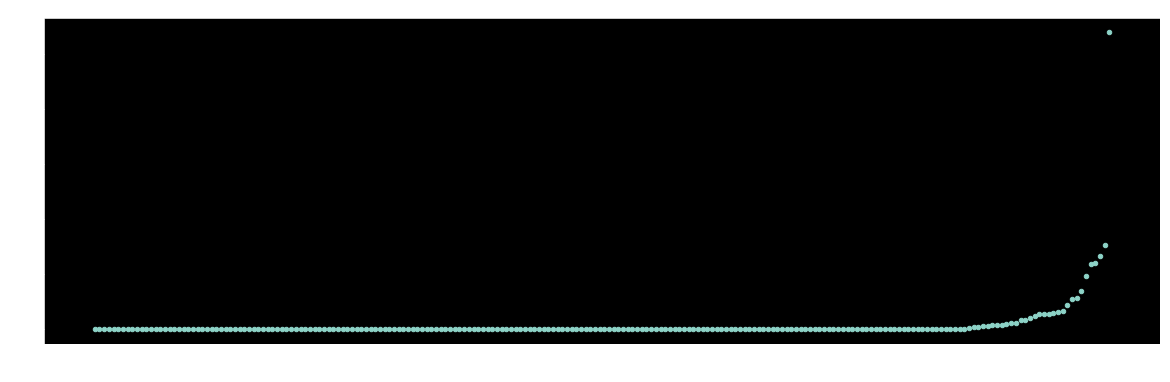

In [93]:
plt.figure(figsize=(20,6))
plt.scatter(range(t7[t7['color']=="yellow"].shape[0]), np.sort(t7[t7['color']=="yellow"]["totals_transactionRevenue"].values), s= 20 )
plt.xlabel('index', fontsize=10)
plt.ylabel('Revenue', fontsize=10)
plt.show()

##### We can see that the number of points in 4th cluster in the second case are much lower and their mean revenue is higher which means that it did a better job at filtering out non zero revenue rows. But there is still no one cluster which divides the data perfectly

In [96]:
t6.groupby(by="cluster", as_index=False).agg({'totals_transactionRevenue':['mean','count']})

cluster totals_transactionRevenue      
                               mean count
0       0                 49668.642  4557
1       1               9322392.777   443

In [97]:
t7.groupby(by="cluster", as_index=False).agg({'totals_transactionRevenue':['mean','count']})

cluster totals_transactionRevenue      
                               mean count
0       0                     0.000  1941
1       1                337336.042  1723
2       2                324132.379  1118
3       3              15653899.083   218

### Unsupervised Model Clustering 2: Gaussian Mixture
##### starting with 2 clusters again, and will increase this number later

In [98]:
gm = GaussianMixture(n_components=2, covariance_type='full').fit(Xtrain) 
t8 = pd.DataFrame(gm.predict(Xtest),ytest)  

In [99]:
colors = {'0':'white', '1':'blue'}
t8 = t8.sort_values(by="totals_transactionRevenue").reset_index()
t8 = t8.rename(index=int, columns={0: "cluster"})
t8['cluster'] = t8["cluster"].astype('str').astype('category')
t8['color'] = t8['cluster'].apply(lambda x: colors[x])

##### We see similar results as kmeans, with one cluster having both kind of sessions while the other cluster exclusively made up of zero revenue rows

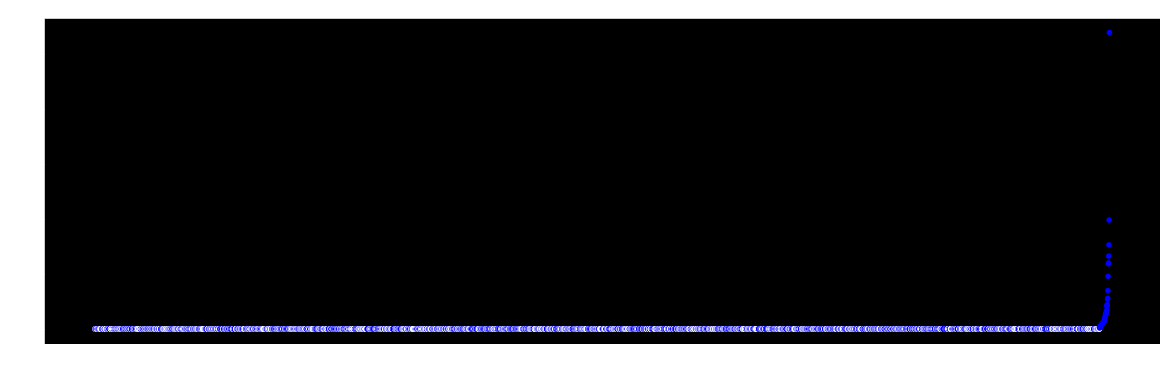

In [100]:
plt.figure(figsize=(20,6))
plt.scatter(range(t8.shape[0]), np.sort(t8["totals_transactionRevenue"].values), c = t8["color"], s= 20 )
plt.xlabel('index', fontsize=10)
plt.ylabel('Revenue', fontsize=10)
plt.show()

In [101]:
gm_aic = []
gm_bic = [] 
K = range(1,10)
for k in K:
    gm = GaussianMixture(n_components=k, covariance_type='full').fit(Xtrain)
    gm_aic.append(gm.aic(Xtrain))
    gm_bic.append(gm.bic(Xtrain))


##### AIC and BIC have an elbow at 3 but they still keep decreasing at a large pace.

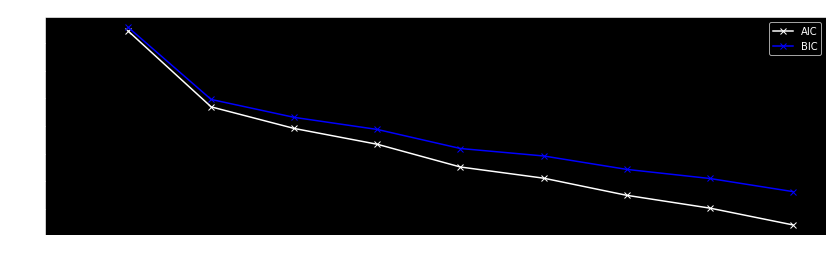

In [102]:
plt.figure(figsize=(14,4))
K = np.arange(1, 10)
plt.plot(K, gm_aic, 'bx-', label = "AIC", color = "white")
plt.plot(K, gm_bic, 'bx-', label = "BIC", color = "blue")
plt.legend(loc='best')
plt.xticks(range(len(K)), K, size='small');


In [53]:
gm = GaussianMixture(n_components=7, covariance_type='full').fit(Xtrain) 
t9 = pd.DataFrame(gm.predict(Xtest),ytest)  
colors = {'0':'white', '1':'blue','2':'red', '3':'yellow','4':'green', '5':'orange', '6':'grey'}
t9 = t9.sort_values(by="totals_transactionRevenue").reset_index()
t9 = t9.rename(index=int, columns={0: "cluster"})
t9['cluster'] = t9["cluster"].astype('str').astype('category')
t9['color'] = t9['cluster'].apply(lambda x: colors[x])

###### Again, we see that increasing the number of clusters has improved the "purity" or homogeneity of the clusters but kmeans performed better

In [54]:
t8.groupby(by="cluster", as_index=False).agg({'totals_transactionRevenue':['mean','count']})

cluster totals_transactionRevenue      
                               mean count
0       0               1713000.393  2543
1       1                     0.000  2457

In [55]:
t9.groupby(by="cluster", as_index=False).agg({'totals_transactionRevenue':['mean','count']})

cluster totals_transactionRevenue      
                               mean count
0       0                     0.000   548
1       1                     0.000   171
2       2                     0.000   828
3       3               2965762.712  1416
4       4                     0.000   544
5       5                     0.000   589
6       6                173274.336   904

### Unsupervised Model Dimensionality reduction 1: PCA
##### starting with PCA as it is one of the most popular methods out there. It is also pretty fast in terms of computation speed

##### Again, there is no clear elbow to guide how many Principal components to choose. 10 components explain 80% of the variance though and that is what we will go with

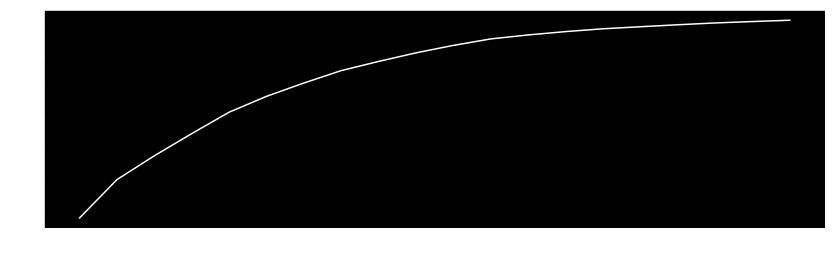

In [56]:
pca = PCA(n_components=20).fit(Xtrain)
plt.figure(figsize=(14,4))
plt.plot(np.arange(1,21).astype('str'), pca.explained_variance_ratio_.cumsum(), color = "white")
plt.xlabel("# of Prcincipal Components")
plt.ylabel("% variance explained, cumulative");

In [57]:
#transorm the dataset using 10 components only, 80% variance explained
pca = PCA(n_components=10).fit(Xtrain)
Xtrain_pca = pca.transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

#### Running prediction models after PCA
#### Ridge Regression

In [58]:
alphas = np.array([2,1,0.1,0.01,0.001,0.0001,0])
for alpha in alphas:
    grid_ridge_pca = GridSearchCV(cv =5, estimator=Ridge(),scoring = make_scorer(rmse, greater_is_better=False), param_grid=dict(alpha=alphas)).fit(Xtrain_pca, ytrain)
print("training RMSE: ", rmse(ytrain, grid_ridge_pca.predict(Xtrain_pca)))
print("testing RMSE:  ", rmse(ytest, grid_ridge_pca.predict(Xtest_pca)))
print("Best alpha parameter: ",  grid_ridge_pca.best_estimator_.alpha)


training RMSE:  19541832.847179435
testing RMSE:   17518450.609199118
Best alpha parameter:  2.0


##### Low regularization leads to bad results. Higher alpha parameters lead to better error results which implies overfitting

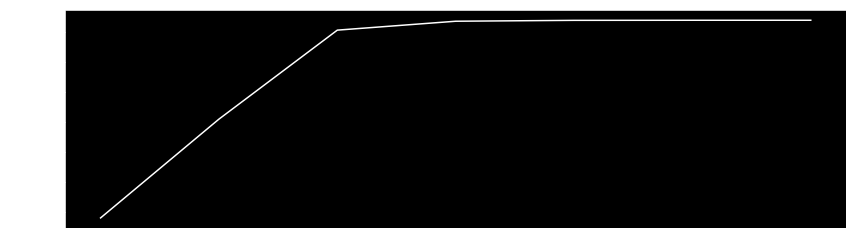

In [59]:
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
ax.plot(alphas.astype(str), grid_ridge_pca.cv_results_['mean_test_score']*-1, color="white");

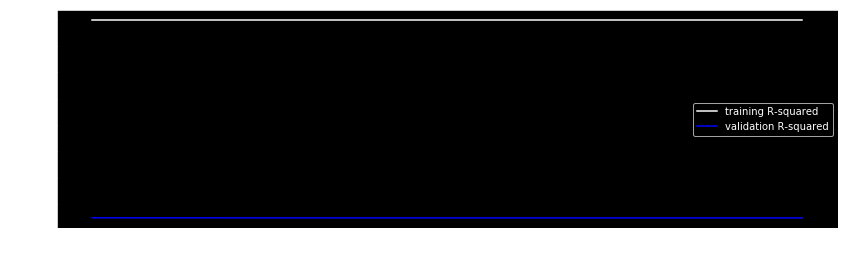

In [60]:
train_score, val_score = validation_curve(Ridge(), Xtrain_pca, ytrain, 'alpha', alphas, cv = 5, scoring = "r2")
plt.subplots(1,1, figsize =(14,4))
plt.plot(alphas.astype(str), np.mean(train_score, 1), color='white', label='training R-squared')
plt.plot(alphas.astype(str), np.mean(val_score, 1), color='blue', label='validation R-squared')
plt.legend(loc='best')
plt.xlabel('alpha param')
plt.ylabel('R squared');

#### Regression Tree

##### Adding features is causing overfitting. We are better off using null model instead

In [61]:
depths = np.array([1,2,3,4,5,6,7,8,9,10])
grid_regtree_pca = GridSearchCV(cv = 5, estimator = DecisionTreeRegressor(), scoring = make_scorer(rmse, greater_is_better = False), param_grid = dict(max_depth = depths)).fit(Xtrain_pca, ytrain)
print("training RMSE: ", rmse(ytrain, grid_regtree_pca.predict(Xtrain_pca)))
print("testing RMSE:  ", rmse(ytest, grid_regtree_pca.predict(Xtest_pca)))
print("Best alpha parameter: ",  grid_regtree_pca.best_estimator_.max_depth)

training RMSE:  18289878.553899083
testing RMSE:   18256362.143709943
Best alpha parameter:  2


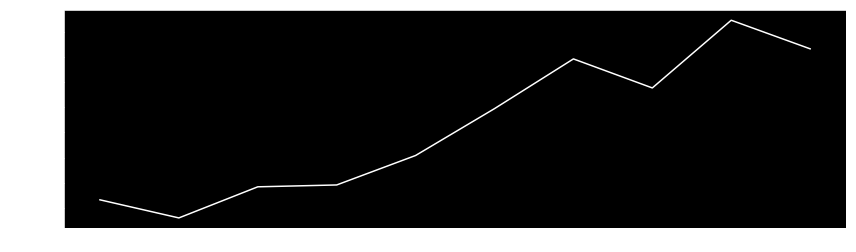

In [62]:
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
ax.plot(depths.astype(str), grid_regtree_pca.cv_results_['mean_test_score']*-1, color="white");

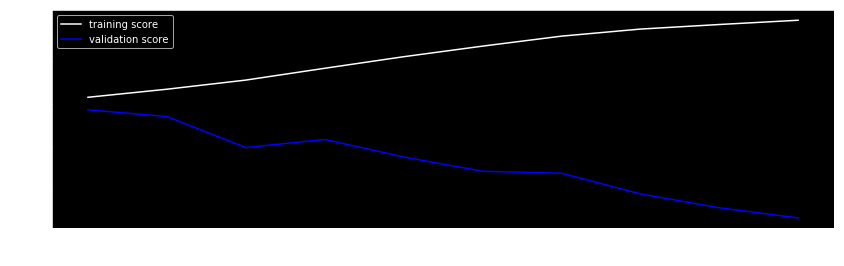

In [63]:
train_score, val_score = validation_curve(DecisionTreeRegressor(), Xtrain, ytrain, 'max_depth', depths, cv = 5)
plt.subplots(figsize =(14,4))
plt.plot(depths.astype(str), np.mean(train_score, 1), color='white', label='training score')
plt.plot(depths.astype(str), np.mean(val_score, 1), color='blue', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('R squared');

### Unsupervised Model Dimensionality reduction 2: ICA
##### ICA can be superior to PCA at times as it maximizes the mutual information stored in the components instead of the variance. Unfortunately, ICA doesn't have many visualization options to choose the number of components, so we will go with 10 like pca

In [64]:
ica = FastICA(n_components=10).fit(Xtrain)
Xtrain_ica = ica.transform(Xtrain)
Xtest_ica = ica.transform(Xtest)

In [65]:
t10 = pd.DataFrame(Xtest_ica, ytest).reset_index()
t10.head()

,totals_transactionRevenue,0,1,2,3,4,5,6,7,8,9
0,0.000,-0.012,-0.002,0.009,0.002,-0.009,-0.006,0.003,0.002,0.008,0.009
1,0.000,0.008,-0.003,0.008,0.003,0.008,-0.005,-0.001,0.003,0.005,0.002
2,0.000,0.009,0.009,-0.007,0.001,-0.008,-0.005,-0.001,0.001,0.001,-0.000
3,0.000,-0.007,-0.011,-0.006,0.003,0.011,0.016,-0.001,0.003,-0.008,-0.007
4,0.000,0.005,0.009,-0.011,0.002,0.010,0.012,-0.000,0.005,0.012,-0.010


##### The components don't do a good job of separating 0 revenue (purple dots from the positive revenue points

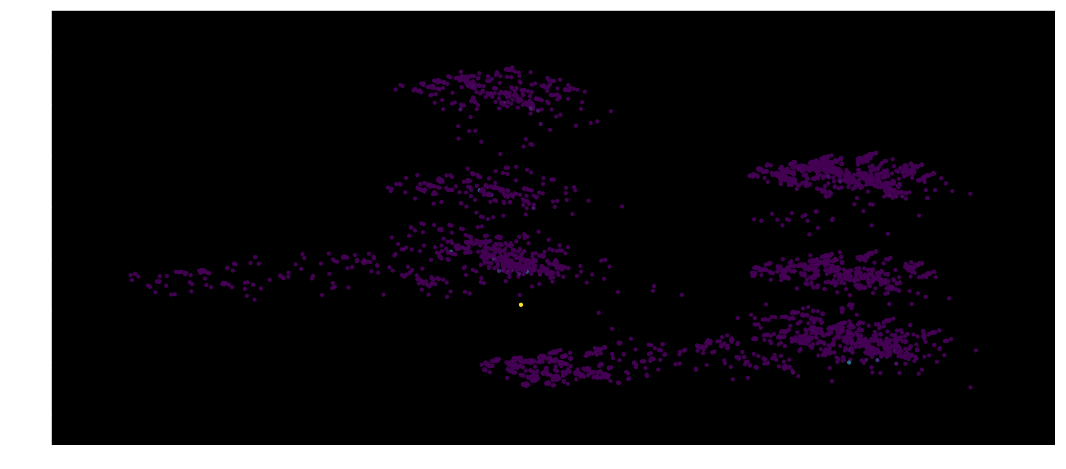

In [66]:
plt.figure(figsize= (18,8))
plt.scatter(t10.iloc[:,1],t10.iloc[:,2], c = t10.iloc[:,0], s = 10);

#### Running prediction models after ICA
#### Ridge Regression

##### Now, we get to see something different.. Removing regularization parameter reduces our valdation RMSE. R squared also is lower for lower alpha values

training RMSE:  19547828.59792587
testing RMSE:   17565575.24796271
Best alpha parameter:  0.1


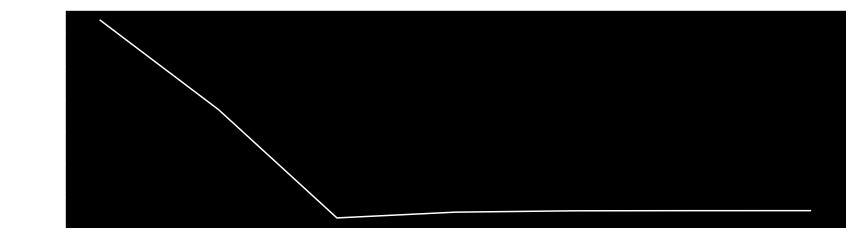

In [67]:
alphas = np.array([2,1,0.1,0.01,0.001,0.0001,0])
for alpha in alphas:
    grid_ridge_ica = GridSearchCV(cv =5, estimator=Ridge(),scoring = make_scorer(rmse, greater_is_better=False), param_grid=dict(alpha=alphas)).fit(Xtrain_ica, ytrain)
print("training RMSE: ", rmse(ytrain, grid_ridge_ica.predict(Xtrain_ica)))
print("testing RMSE:  ", rmse(ytest, grid_ridge_ica.predict(Xtest_ica)))
print("Best alpha parameter: ",  grid_ridge_ica.best_estimator_.alpha)

fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
ax.plot(alphas.astype(str), grid_ridge_ica.cv_results_['mean_test_score']*-1, color="white");

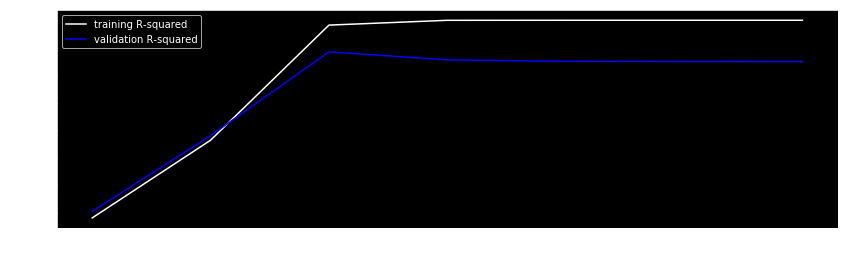

In [68]:
train_score, val_score = validation_curve(Ridge(), Xtrain_ica, ytrain, 'alpha', alphas, cv = 5, scoring = "r2")
plt.subplots(1,1, figsize =(14,4))
plt.plot(alphas.astype(str), np.mean(train_score, 1), color='white', label='training R-squared')
plt.plot(alphas.astype(str), np.mean(val_score, 1), color='blue', label='validation R-squared')
plt.legend(loc='best')
plt.xlabel('alpha param')
plt.ylabel('R squared');

#### Regression Tree
##### Again, adding more features to a tree based regression doesn't help. quite the contrary

training RMSE:  19560172.372741885
testing RMSE:   18164562.83657189
Best alpha parameter:  1


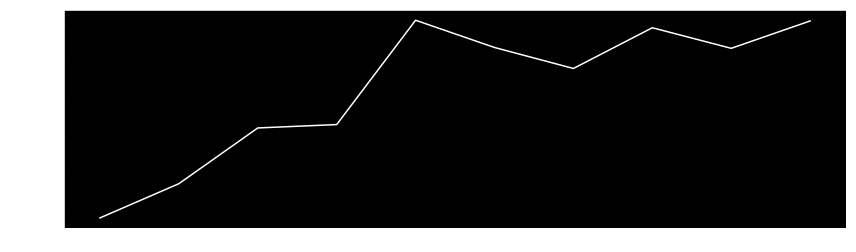

In [69]:
depths = np.array([1,2,3,4,5,6,7,8,9,10])
grid_regtree_ica = GridSearchCV(cv = 5, estimator = DecisionTreeRegressor(), scoring = make_scorer(rmse, greater_is_better = False), param_grid = dict(max_depth = depths)).fit(Xtrain_ica, ytrain)
print("training RMSE: ", rmse(ytrain, grid_regtree_ica.predict(Xtrain_ica)))
print("testing RMSE:  ", rmse(ytest, grid_regtree_ica.predict(Xtest_ica)))
print("Best alpha parameter: ",  grid_regtree_ica.best_estimator_.max_depth)

fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
ax.plot(depths.astype(str), grid_regtree_ica.cv_results_['mean_test_score']*-1, color="white");

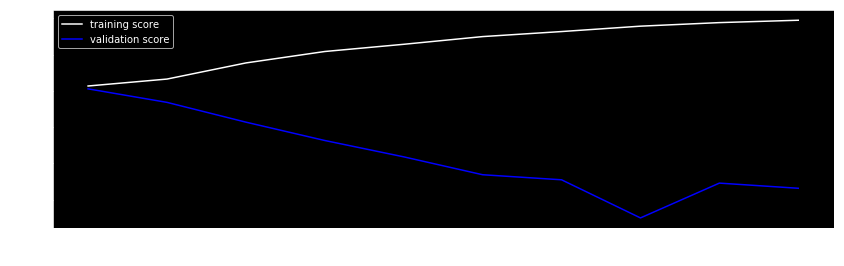

In [70]:
train_score, val_score = validation_curve(DecisionTreeRegressor(), Xtrain_ica, ytrain, 'max_depth', depths, cv = 5)
plt.subplots(figsize =(14,4))
plt.plot(depths.astype(str), np.mean(train_score, 1), color='white', label='training score')
plt.plot(depths.astype(str), np.mean(val_score, 1), color='blue', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth')
plt.ylabel('R squared');

# Conclusion

##### The RMSES for both the train and test set are seen in the table and chart below. It is clear that Ridge regression is the better than regression trees but it is still a poor model.

In [71]:
acc = pd.DataFrame()
acc['model'] = ["Regression Tree", "Regression Tree PCA","Regression Tree ICA","Ridge Regression", "Ridge Regression PCA","Ridge Regression ICA"]
acc['TrainRMSE'] = [ rmse(ytrain, grid_regtree.predict(Xtrain)), rmse(ytrain, grid_regtree_pca.predict(Xtrain_pca)), rmse(ytrain, grid_regtree_ica.predict(Xtrain_ica)),
                   rmse(ytrain, grid_ridge.predict(Xtrain)), rmse(ytrain, grid_ridge_pca.predict(Xtrain_pca)), rmse(ytrain, grid_ridge_ica.predict(Xtrain_ica))]
acc['TestRMSE'] = [ rmse(ytest, grid_regtree.predict(Xtest)), rmse(ytest, grid_regtree_pca.predict(Xtest_pca)), rmse(ytest, grid_regtree_ica.predict(Xtest_ica)),
                   rmse(ytest, grid_ridge.predict(Xtest)), rmse(ytest, grid_ridge_pca.predict(Xtest_pca)), rmse(ytest, grid_ridge_ica.predict(Xtest_ica))]
acc

,model,TrainRMSE,TestRMSE
0,Regression Tree,19548934.700,18219318.983
1,Regression Tree PCA,18289878.554,18256362.144
2,Regression Tree ICA,19560172.373,18164562.837
3,Ridge Regression,19461078.475,17506169.065
4,Ridge Regression PCA,19541832.847,17518450.609
5,Ridge Regression ICA,19547828.598,17565575.248


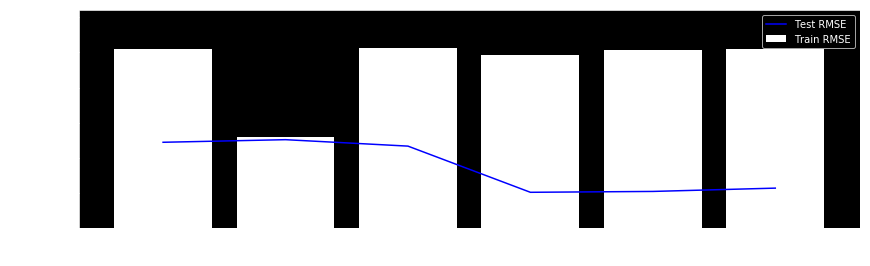

In [74]:
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.ticklabel_format(style="plain", useOffset=False)
ax.bar(acc.model,acc.TrainRMSE, color = 'white', label = "Train RMSE")
ax.plot(acc.model, acc.TestRMSE, color='blue', label='Test RMSE')
plt.ylim(17000000,20100000)
plt.legend(loc='best')
plt.xlabel('Models')
plt.ylabel('RMSE');


### Project outline: 

- Read data into Jupyter notebook, use pandas to import data into a data frame
- Preprocess data: Explore data, check for missing data and apply data scaling. Justify the type of scaling used.
- Goal is to predict the **total transaction revenue**. 
- Decide aboute a good evaluation strategy and justify your choice.
- Split dataset into train and test dataset. 
- Choose two supervised learning model of your choice to train on train set. Use proper methods to find the best parameters. Evaluate your method on test data according to evaluation strategy. 
- Choose two unsupervised learning models, clustering, to train on your dataset. Discuss results. 
- Choose two unsupervised learning models, dimentionally reduction, and train it your dataset. Now use the same supervised learning models above on reduced dataset. Can you see any differences? Discuss the result. 

### Deliverables:
- Submit IPython notebook. Use markdown to provide an inline comments for this project.
- Submit only one notebook. Before submitting, make sure everything runs as expected. To check that, restart the kernel (in the menubar, select Kernel > Restart) and then run all cells (in the menubar, select Cell > Run All).
- Visualization expected. 

### Dataset Description
This is an online Merchandise Store customer dataset. Goal is to predict the total transaction revenue. 
Each row in the dataset is one visit to the store. 

Data Fields
- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).
- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.